In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import umap
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

#import Lambda
from tensorflow.keras.layers import Lambda

import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,  load_img
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input, Lambda
#import concatenate
from tensorflow.keras.layers import Concatenate

c:\Users\levy\miniconda3\envs\keras\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\levy\miniconda3\envs\keras\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\levy\miniconda3\envs\keras\lib\site-packages\umap\distances.py:1086: NumbaDepreca

In [2]:
# load mnist dataset from keras

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

classes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 0]

In [3]:
# define triplet generator

def data_generator(batch_size=64):
    while True:
        a = []
        p = []
        n = []
        for _ in range(batch_size):
            pos_neg = random.sample(classes, 2)
            positive_samples = random.sample(list(x_train[y_train == pos_neg[0]]), 2)
            negative_sample = random.choice(list(x_train[y_train == pos_neg[1]]))

            a.append(positive_samples[0])
            p.append(positive_samples[1])
            n.append(negative_sample)
        yield ([np.array(a), np.array(p), np.array(n)], np.zeros((batch_size, 1)).astype('float32'))


In [4]:
def triplet_loss(y_true, y_pred):
    anchor_out = y_pred[:, 0:100]
    positive_out = y_pred[:, 100:200]
    negative_out = y_pred[:, 200:300]

    pos_dist = K.sum(K.abs(anchor_out - positive_out), axis=1)
    neg_dist = K.sum(K.abs(anchor_out - negative_out), axis=1)

    probs = K.softmax([pos_dist, neg_dist], axis=0)

    return K.mean(K.abs(probs[0]) + K.abs(1.0 - probs[1]))



input_layer = Input((28, 28, 1))
X = Conv2D(32, (3, 3), activation="relu")(input_layer)
X = MaxPool2D()(X)
X = Conv2D(64, (3, 3), activation="relu")(X)
X = MaxPool2D()(X)
X = Conv2D(128, (3, 3), activation="relu")(X)
X = MaxPool2D()(X)
X = Flatten()(X)
X = Dense(100, activation="relu")(X)

model = Model(input_layer, X)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

In [5]:
triplet_model_a = Input((28, 28, 1))
triplet_model_p = Input((28, 28, 1))
triplet_model_n = Input((28, 28, 1))

triplet_model_out = Concatenate()([model(triplet_model_a), model(triplet_model_p), model(triplet_model_n)])
triplet_model = Model([triplet_model_a, triplet_model_p, triplet_model_n], triplet_model_out)
triplet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 100)          105572      ['input_2[0][0]',                
                                                                  'input_3[0][0]',          

In [6]:
triplet_model.compile(loss = triplet_loss, optimizer='adam')

In [7]:
triplet_model.fit(data_generator(), epochs=3, steps_per_epoch=50)

Epoch 1/3
50/50 [==============================] - 89s 1s/step - loss: 0.3056
Epoch 2/3
50/50 [==============================] - 71s 1s/step - loss: 0.1522
Epoch 3/3
50/50 [==============================] - 71s 1s/step - loss: 0.0990


In [13]:
model_embeddings = triplet_model.layers[3].predict(x_test)

313/313 [==============================] - 1s 3ms/step


In [9]:
reduced_embeddings = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='correlation').fit_transform(model_embeddings)
print(reduced_embeddings.shape)

(10000, 2)


In [10]:
import matplotlib.pyplot as plt

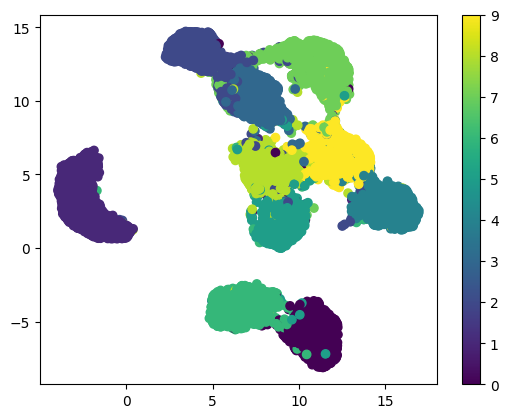

In [11]:
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:,1], c=y_test)
plt.colorbar()

In [12]:
import sklearn


rf = sklearn.ensemble.RandomForestClassifier

AttributeError: module 'sklearn' has no attribute 'ensemble'